# MLPベースのベースライン分類器
- モデル：`esm2`

## 1. 必要ライブラリのインポート

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

### 1.1 データの読み込み

In [3]:
X = np.load("../data/embedding-vectors/esm2/mean_vectors.npy")  # shape: (N, 2560)
df = pd.read_csv("../data/gpcr_dataset.csv")
y = df["class"].values  # Class A〜E


print(X.shape)
print(y.shape)
print(df)

(7716, 2560)
(7716,)
        id                                                seq class
0        1  MGPPGNDSDFLLTTNGSHVPDHDVTEERDEAWVVGMAILMSVIVLA...     A
1        2  AIAAVITFLILFTIFGNALVILAVLTSRSLRAPQNLFLVSLAAADI...     A
2        3  MAPWPHRNGSLALWSDAPTLDPSAANTSGLPGVPWAAALAGALLAL...     A
3        4  MGAGALVLGASEPGNLSSAAPLPDGVATAARLLVPASPPASLLPPA...     A
4        5  MGSLQPDAGNSSWNGTEAPGGGTRATPYSLQVTLTLVCLAGLLMLF...     A
...    ...                                                ...   ...
7711  7712  MENLNTTSTAALTGMTKQENDASYAVLLIADFTSIIGCTLVLLGFW...     E
7712  7713  MKVLQEINLTYSILVIADFSSIFGCLLVLIAFKKLKLLRNHITRVI...     E
7713  7714  MTIMSDIIAQRTILLIADFSSIIGCSLVLIGFWRLKLLRNHITKII...     E
7714  7715  MENLNTTSTAALTGMTKQENDASYAVLLIADFTSIIGCTLVLLGFW...     E
7715  7716  MGLLDGNPANETSLVLLLFADFSSMLGCMAVLIGFWRLKLLRNHVT...     E

[7716 rows x 3 columns]


### 1.2 ラベルを数値化

In [4]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

print(y_enc)

[0 0 0 ... 4 4 4]


### 1.3 Torch Tensor へ

In [5]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_enc, dtype=torch.long)

## 2. MLP モデル定義

In [6]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=2560, hidden_dim=512, num_classes=5):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

## 3. 1 Fold 分の学習

In [23]:
def train_one_fold(X_train, y_train, X_val, y_val, epochs=200):
    model = MLPClassifier().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    train_pres, val_pres = [], []
    train_recs, val_recs = [], []
    train_f1s, val_f1s = [], []

    for epoch in tqdm(range(epochs)):
        # --- 学習 ---
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        acc = accuracy_score(y_train.cpu(), preds.cpu())
        pre = precision_score(y_train.cpu(), preds.cpu(), average="macro", zero_division=0)
        rec = recall_score(y_train.cpu(), preds.cpu(), average="macro", zero_division=0)
        f1 = f1_score(y_train.cpu(), preds.cpu(), average="macro", zero_division=0)

        train_losses.append(loss.item())
        train_accs.append(acc)
        train_pres.append(pre)
        train_recs.append(rec)
        train_f1s.append(f1)

        # --- 評価 ---
        model.eval()

        with torch.no_grad():
            outputs = model(X_val)
            val_loss = criterion(outputs, y_val).item()
            preds = outputs.argmax(1)
            val_acc = accuracy_score(y_val.cpu(), preds.cpu())
            val_pre = precision_score(y_val.cpu(), preds.cpu(), average="macro", zero_division=0)
            val_rec = recall_score(y_val.cpu(), preds.cpu(), average="macro")
            val_f1 = f1_score(y_val.cpu(), preds.cpu(), average="macro", zero_division=0)

        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_pres.append(val_pre)
        val_recs.append(val_rec)
        val_f1s.append(val_f1)

    print(f"\033[91mAccuracy: {acc:.4f}\033[92m Precision: {pre:.4f}\033[93m Recall: {rec:.4f}\033[94m F1: {f1:.4f}\033[0m")

    cm = confusion_matrix(y_val.cpu(), preds.cpu())
    labels = le.inverse_transform(unique_labels(y_val.cpu()))
    print(pd.DataFrame(cm, index=labels, columns=labels))

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "train_pres": train_pres,
        "val_pres": val_pres,
        "train_recs": train_recs,
        "val_recs": val_recs,
        "train_f1s": train_f1s,
        "val_f1s": val_f1s
    }

### 3.1 Plot

In [24]:
def plot_metric(metric_name, ylabel):
    plt.figure(figsize=(8, 5))
    
    for i, res in enumerate(fold_results):
        plt.plot(epochs, res[f"train_{metric_name}"], color='gray', alpha=0.4)
        plt.plot(epochs, res[f"val_{metric_name}"], color='C0', alpha=0.4)
        
    # 平均線
    val_means = np.mean([res[f"val_{metric_name}"] for res in fold_results], axis=0)
    plt.plot(epochs, val_means, color='C1', linewidth=2, label='Val mean')
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(f"Training curves ({metric_name.capitalize()}) across 5 folds")
    plt.legend()
    plt.grid(True)
    plt.show()

## 4. 学習

In [27]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_enc), 1):
    print(f"\033[34m[Fold {fold} / 5]\033[0m")
    
    X_train, X_val = X_tensor[train_idx].cuda(), X_tensor[val_idx].cuda()
    y_train, y_val = y_tensor[train_idx].cuda(), y_tensor[val_idx].cuda()
    results = train_one_fold(X_train, y_train, X_val, y_val, epochs=200)
    fold_results.append(results)

[Fold 1 / 5]


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 58.53it/s]


Accuracy: 0.9697 Precision: 0.5823 Recall: 0.5480 F1: 0.5628
      A   B    C  D  E
A  1059   0    2  0  0
B     8  76    7  0  0
C    11   0  374  0  0
D     0   0    3  0  0
E     1   0    3  0  0
[Fold 2 / 5]


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 58.16it/s]


Accuracy: 0.9704 Precision: 0.5837 Recall: 0.5524 F1: 0.5660
      A   B    C  D  E
A  1059   0    2  0  0
B    14  67    9  0  0
C    16   0  370  0  0
D     0   0    3  0  0
E     1   0    2  0  0
[Fold 3 / 5]


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 58.10it/s]


Accuracy: 0.9691 Precision: 0.5830 Recall: 0.5478 F1: 0.5629
      A   B    C  D  E
A  1055   0    5  0  0
B     7  79    5  0  0
C    14   0  372  0  0
D     0   0    3  0  0
E     2   0    1  0  0
[Fold 4 / 5]


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 58.82it/s]


Accuracy: 0.9694 Precision: 0.5829 Recall: 0.5467 F1: 0.5620
      A   B    C  D  E
A  1051   1    8  0  0
B    13  72    6  0  0
C    12   0  374  0  0
D     0   0    2  0  0
E     1   0    3  0  0
[Fold 5 / 5]


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 58.94it/s]

Accuracy: 0.9705 Precision: 0.5846 Recall: 0.5533 F1: 0.5670
      A   B    C  D  E
A  1053   1    6  0  0
B    10  69   12  0  0
C     8   0  378  0  0
D     0   0    2  0  0
E     2   0    2  0  0


## 5. 平均＋標準偏差のプロット

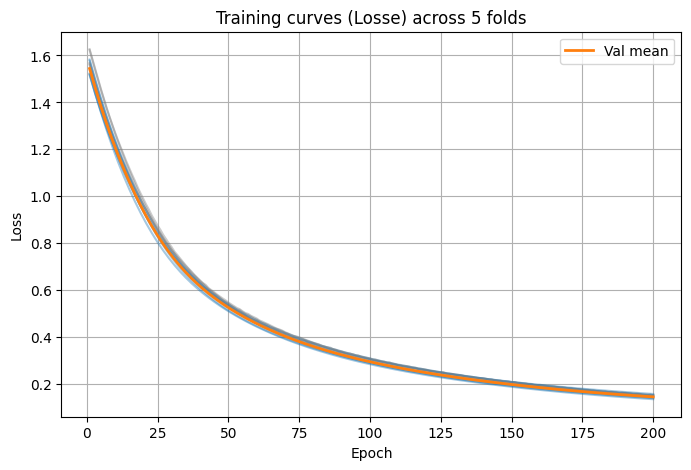

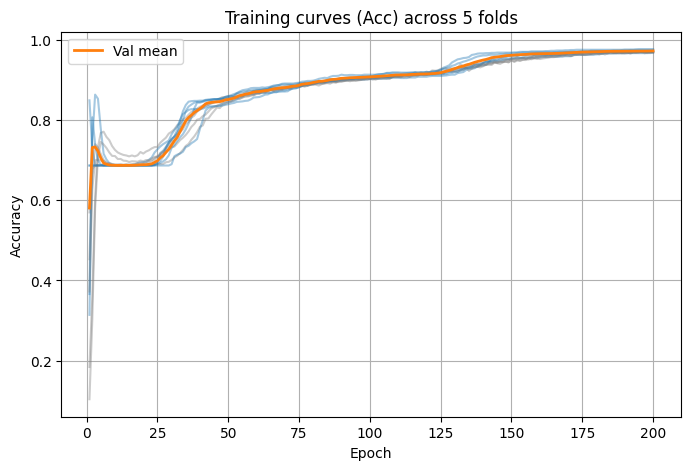

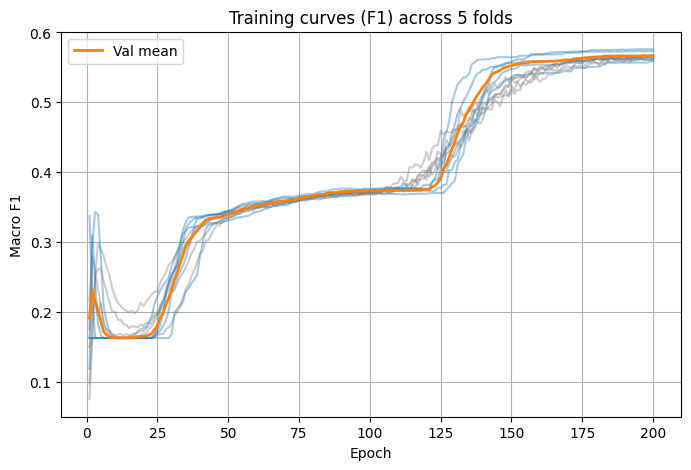

In [28]:
epochs = range(1, len(fold_results[0]["train_losses"]) + 1)

plot_metric("losses", "Loss")
plot_metric("accs", "Accuracy")
plot_metric("f1s", "Macro F1")